**CLASSIFICATION**

Welcome dear reader. In this jupyter-notebook, you will meet the classification of nothing less but glass. Have you ever wondered about how a computer would classify your bedroom window? Wonder no more!

In [5]:
# imports
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from toolbox_02450 import rocplot, confmatplot
import pandas as pd
from sklearn import model_selection
from tqdm import tqdm
import torch

font_size = 15
plt.rcParams.update({'font.size': font_size})

In [45]:
# loading data
filename = 'data/glass.csv'
df = pd.read_csv(filename)

# defining x and y for the linear regression
#       all attributes except RI
X = np.array(df.iloc[:,1:10])
#       number of attributes
M = 9
#       type
y = np.array(df.iloc[:,10])

In [46]:
# the format of C needs to be this, so it is usable with torch, see before and after:
print(y)
y[y>3] = y[y>3] - 1
y = y - 1
print(y)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


In [52]:
# K = K_outer = K_inner
K = 10
CV_outer = model_selection.KFold(n_splits=K,shuffle=True)

#* INIT FOR LOGISTIC REGRESSION
# init for lambda-inner-loop
lambda_interval = np.logspace(-8, 2, 50)
train_error_rate = np.empty((K,len(lambda_interval)))
test_error_rate = np.empty((K,len(lambda_interval)))
# init for error save
log_train_error = np.zeros(10)
log_test_error = np.zeros(10)

opt_lambda = np.zeros(10)
#coefficient_norm = np.zeros(len(lambda_interval))


#* INIT FOR BASE-LINE
base_line_train_err = np.zeros(10)
base_line_test_err = np.zeros(10)

#* INIT FOR ANN-CLASSIFICATION
max_iter = 20000
tolerance = 0.000001
logging_frequency = 1000
best_final_loss = 1e100
n_replicates = 1
ANN_error_test = np.zeros(K)
ANN_error_train = np.zeros(K)

h = [i for i in range(1,11)]

C = len(np.unique(y))

opt_h = np.zeros(10)




#* OUTER LOOP
for m, (train_index, test_index) in tqdm(enumerate(CV_outer.split(X,y))):
    X_train, X_test = X[train_index, :], X[test_index, :]
    y_train, y_test = y[train_index], y[test_index]


    # TODO: CHECK IF THIS STANDARDIZATION IS CORRECT.
    mu = np.mean(X_train, axis=0)
    sigma = np.std(X_train, axis = 0)

    X_train = (X_train - mu)/sigma
    X_test = (X_test - mu)/sigma

    #* INNER LOOP
    ## ## GOAL: finding best lambda & finding best number of hidden neurons
    CV_inner = model_selection.KFold(n_splits=K,shuffle=True)
    
    #init for optimal h
    h_error_train = np.zeros(K)
    h_error_test = np.zeros(K)
    j = 0
    for _, (train_index_inner, test_index_inner) in enumerate(CV_inner.split(X_train, y_train)):
        # printing
        print("outer_loop: " + str(m+1) + "/10. inner_loop: " + str(j+1) + "/10.",end='\r')

        X_train_inner, X_test_inner = X_train[train_index_inner, :], X_train[test_index_inner, :]
        y_train_inner, y_test_inner = y_train[train_index_inner], y_train[test_index_inner]

        

        ##########################
        #* Finding the best lambda:
        # allows us to iterate over a arbitray number of lambdas
        for k in range(0, len(lambda_interval)):
            #'newton-cg' gives better results
            mdl = LogisticRegression(penalty='l2', solver='newton-cg', C=1/lambda_interval[k], max_iter=100)
            # but the other is faster but outputs hella lot of warnings:
            # mdl = LogisticRegression(penalty='l2', C=1/lambda_interval[k], max_iter=100)
            
            mdl.fit(X_train_inner, y_train_inner)

            y_train_est_inner = mdl.predict(X_train_inner).T
            y_test_est_inner = mdl.predict(X_test_inner).T
            
            train_error_rate[j,k] = np.sum(y_train_est_inner != y_train_inner) / len(y_train_inner)
            test_error_rate[j,k] = np.sum(y_test_est_inner != y_test_inner) / len(y_test_inner)

            # føler ikke det her skal bruges
            #w_est = mdl.coef_[0] 
            #coefficient_norm[k] = np.sqrt(np.sum(w_est**2))


        #* Finding the optimal amount of hidden layers:
        X_train_inner, X_test_inner = torch.tensor(X_train_inner, dtype=torch.float), torch.tensor(X_test_inner, dtype=torch.float)
        y_train_inner, y_test_inner = torch.tensor(y_train_inner), torch.tensor(y_test_inner)
        # reshaping helps torch
        #y_test_inner = torch.reshape(y_test_inner, (y_test_inner.shape[0],1))
        #y_train_inner = torch.reshape(y_train_inner, (y_train_inner.shape[0],1))

        n_hidden_units_inner = h[j]
        model_inner = lambda: torch.nn.Sequential(
                    torch.nn.Linear(M, n_hidden_units_inner), #M features to H hiden units
                    # 1st transfer function, either Tanh or ReLU:
                    #torch.nn.Tanh(),                            
                    torch.nn.ReLU(),
                    torch.nn.Linear(n_hidden_units_inner,n_hidden_units_inner),
                    torch.nn.ReLU(),
                    torch.nn.Linear(n_hidden_units_inner, C),
                    torch.nn.Softmax(dim=1)) #softmax as we want classes

        # loss function for multinomial classification
        loss_fn = torch.nn.CrossEntropyLoss()

        for r in range(n_replicates):
            net_inner = model_inner()

            torch.nn.init.xavier_uniform_(net_inner[0].weight)
            torch.nn.init.xavier_uniform_(net_inner[2].weight)

            optimizer = torch.optim.Adam(net_inner.parameters())

            learning_curve = []
            old_loss = 1e6
            for i in range(max_iter):
                y_est = net_inner(X_train_inner)
                #y_class = torch.max(y_est, dim=1)[1]
                loss = loss_fn(y_est, y_train_inner)
                loss_value = loss.data.numpy()
                learning_curve.append(loss_value)


                p_delta_loss = np.abs(loss_value - old_loss)/old_loss
                if p_delta_loss < tolerance: break
                old_loss = loss_value


                #if (i != 0) & ((i+1) % logging_frequency == 0):
                #    print_str = '\t\t' + str(i+1) + '\t' + str(loss_value) + '\t' + str(p_delta_loss)
                #    print(print_str)
                optimizer.zero_grad(); loss.backward(); optimizer.step()


        y_pred_inner = net_inner(X_test_inner)
        
        softmax_logits = net_inner(X_test_inner)
        y_test_est = (torch.max(softmax_logits, dim=1)[1]).data.numpy() 
        h_error_test[j]  = np.sum(y_test_est != np.array(y_test_inner))/len(y_test_inner)
        # print(f'y_pred inner : {y_pred_inner}')
        # print(f'y_test_est{y_test_est}')
        # print(f'y_test inner{y_test_inner}')
        # print(f'h_error_test{h_error_test[j]}')

         
        #h_error_train[j] = best_final_loss
        j += 1

    #* Optimal values found from inner loop
    #  the smallesst of the means of the differnet lambdas
    opt_lambda[m] = lambda_interval[np.argmin(np.mean(test_error_rate,axis=0))]
    
    # print('Shit for debgging: ')
    # print(h_error_test)
    # print(np.argmin(h_error_test))
    # print(h[np.argmin(h_error_test)])
    opt_h[m] = h[np.argmin(h_error_test)]


    #* CLASSIFICATION
    ##########################
    ## BASELINE
    # find out which class has the highest count
    big_class = np.argmax([np.count_nonzero(y_train == i) for i in range(1,7)])
    # assign everything to this class (calculate error rate)
    base_line_train_err[m] = np.sum(y_train != big_class)/len(y_train)
    base_line_test_err[m] = np.sum(y_test != big_class)/len(y_test)


    ##########################
    ## Logistic Regression
    log = LogisticRegression(penalty='l2', C=1/opt_lambda[m], max_iter=1000)
    log.fit(X_train, y_train)
    y_train_est = log.predict(X_train)
    y_test_est = log.predict(X_test)

    log_train_error[m] = np.sum(y_train_est != y_train)/len(y_train)
    log_test_error[m] = np.sum(y_test_est != y_test)/len(y_test)

    ##########################
    ## ANN-Classification

    model = lambda: torch.nn.Sequential(
                    torch.nn.Linear(M, int(opt_h[m])), #M features to H hiden units
                    # 1st transfer function, either Tanh or ReLU:
                    #torch.nn.Tanh(),                            
                    torch.nn.ReLU(),
                    torch.nn.Linear(int(opt_h[m]),int(opt_h[m])),
                    torch.nn.ReLU(),
                    torch.nn.Linear(int(opt_h[m]), C), # H hidden units to 1 output neuron
                    torch.nn.Softmax(dim=1) # final tranfer function
                    )


    X_train, y_train = torch.tensor(X_train, dtype = torch.float), torch.tensor(y_train)
    X_test, y_test = torch.tensor(X_test, dtype = torch.float), torch.tensor(y_test)
    n_replicates = 3
    for r in range(n_replicates):
        net = model()

        torch.nn.init.xavier_uniform_(net[0].weight)
        torch.nn.init.xavier_uniform_(net[2].weight)

        optimizer = torch.optim.Adam(net.parameters())

        learning_curve = []
        old_loss = 1e6
        for i in range(max_iter):
            y_est = net(X_train)
            #y_class = torch.max(y_est, dim=1)[1]
            loss = loss_fn(y_est, y_train)
            loss_value = loss.data.numpy()
            learning_curve.append(loss_value)


            p_delta_loss = np.abs(loss_value - old_loss)/old_loss
            if p_delta_loss < tolerance: break
            old_loss = loss_value


            # if (i != 0) & ((i+1) % logging_frequency == 0):
                #print_str = '\t\t' + str(i+1) + '\t' + str(loss_value) + '\t' + str(p_delta_loss)
                ###print(print_str)
            optimizer.zero_grad(); loss.backward(); optimizer.step()

        

        #print('\t\tFinal Loss:')
        #print_str = '\t\t' + str(i+1) + '\t' + str(loss_value) + '\t' + str(p_delta_loss)
        ##print(print_str)

        if loss_value < best_final_loss:
            best_net = net
            best_final_loss = loss_value
            best_learning_curve = learning_curve
        
    
    softmax_logits = net(X_test)
    y_test_est = (torch.max(softmax_logits, dim=1)[1]).data.numpy() 
    ANN_error_test[m] = np.sum(y_test_est != np.array(y_test))/len(y_test)




# WARNING: Inden du kligger på den flotte trekant.
# Det tager cirka 20 min

0it [00:00, ?it/s]

1it [00:49, 49.53s/it]

2it [02:49, 90.93s/it]

3it [04:45, 102.37s/it]

c:\Users\magnu\anaconda3\envs\py39\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


4it [06:44, 108.90s/it]

5it [08:36, 109.96s/it]

c:\Users\magnu\anaconda3\envs\py39\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


6it [10:32, 112.22s/it]

7it [12:21, 111.19s/it]

8it [14:09, 110.06s/it]

c:\Users\magnu\anaconda3\envs\py39\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


9it [16:13, 114.32s/it]

c:\Users\magnu\anaconda3\envs\py39\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
c:\Users\magnu\anaconda3\envs\py39\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
c:\Users\magnu\anaconda3\envs\py39\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
c:\Users\magnu\anaconda3\envs\py39\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
c:\Users\magnu\anaconda3\envs\py39\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
10it [18:17, 109.71s/it]


In [53]:
print("{:<15} | {:<15} {:<15} {:<15} {:<15} {:<15}".format('Outer fold i', 'h', 'E_ANN', 'lambda', 'E_log', 'E_base'))
print("-----------------------------------------------------------------------------------------")
for i in range(10):
    print("{:<15} | {:<15} {:<15.3f} {:<15.6f} {:<15.3f} {:<15.7f}".format(i+1, int(opt_h[i]), ANN_error_test[i], opt_lambda[i], log_test_error[i], base_line_test_err[i]))


Outer fold i    | h               E_ANN           lambda          E_log           E_base         
-----------------------------------------------------------------------------------------
1               | 6               0.364           0.355648        0.409           0.6818182      
2               | 2               0.455           0.054287        0.409           0.6363636      
3               | 2               0.545           1.456348        0.500           0.7272727      
4               | 5               0.227           0.054287        0.318           0.4545455      
5               | 6               0.333           0.033932        0.333           0.8571429      
6               | 10              0.524           0.002024        0.524           0.6190476      
7               | 4               0.476           0.054287        0.476           0.7619048      
8               | 9               0.429           0.355648        0.333           0.6190476      
9               | 9         

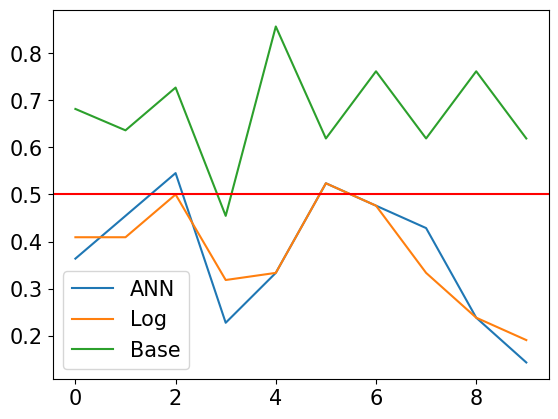

In [69]:
plt.plot(ANN_error_test)
plt.plot(log_test_error)
plt.plot(base_line_test_err)
plt.axhline(0.5,color='red')
plt.legend(['ANN', 'Log', 'Base'])